## Setup

In [ ]:
dir = dirname(pwd()) * "/PROJECT"
include(dir * "/functions/Preamble.jl")
@everywhere dir = dirname(pwd()) * "/PROJECT"

t0 = now()

In [5]:
# Hamiltonian constants
@everywhere global const λ::Float64 = 1
@everywhere global const ξ::Float64 = 0

# which dynamics to use (only affects microcanonical functions)
@everywhere global const twoFlip::Bool = false

# demon quantisation
@assert (λ==1 && ξ==0) || (λ==0 && ξ==1) # otherwise demons will break b/c not quantised
@everywhere global const δE::Int = (λ==0) ? 8*ξ : 4*λ

## Data Structure


In [8]:
@everywhere include(dir * "/functions/DataStructure.jl")
@everywhere include(dir * "/functions/Plotting.jl")
@everywhere include(dir * "/functions/Statistics.jl")
@everywhere include(dir * "/functions/Simulation.jl")

## Thermal Conductivity

### Microcanonical Dynamics

In [53]:
@everywhere include(dir * "/functions/simulationFunctions/MicroKubo.jl")

In [60]:
# PARAMETERS
L = [10, 10, 10]
PBC = [true, true, true]
Basis = DiamondBasis()

Tmin = 0.01
Tmax = 10.0
NumT = 30

#Tmax *= (λ == 0 ? 1.0 : 0.5)
T = range(Tmin, Tmax, length=NumT)

𝒽 = [0] #range(0, 1, length=7)

num_histories = 15
therm_runtime = 10000
runtime = 10000
t_therm = 5000
t_autocorr = 100
N_blocks = -1
t_cutoff = 100

allComponents = false

# EVALUATION
κ, C, Diff, M, ℙ, κStd, CStd, DiffStd, MStd, ℙStd = MKuboSimulation(L, PBC, Basis, num_histories, runtime, therm_runtime, t_therm, t_autocorr, N_blocks, t_cutoff, T, 𝒽, allComponents);

In [1]:
#for t in testing
#    scatter(t[1], t[3], color=:black) # t[2]=h=0 for now
#end

LoadError: UndefVarError: κ not defined

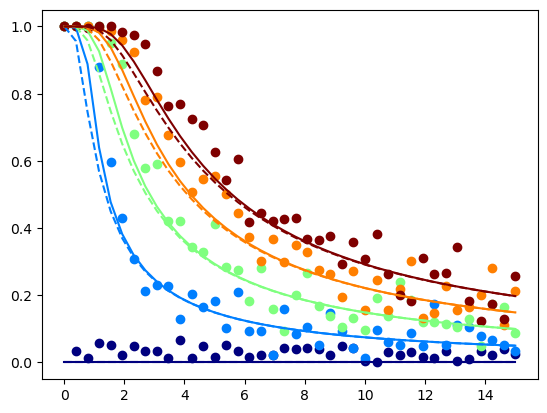

In [64]:
now()

In [ ]:
colors = jetmap(length(𝒽));

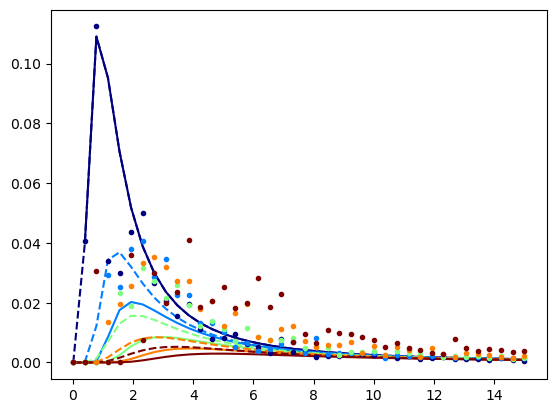

In [82]:
figure()
Tfun = (M, h) -> (h .+ 0.5 .* M .^ 3) ./ atanh.(M)
function Mfun(T, h)
    m = zeros(length(T))
    
    if h==0
        return m
    end
    
    for i in eachindex(T)
        m[i] = find_zero((M) -> Tfun(M, h) - T[i], (0, 1))
    end
    return m
end

Mfun0 = (T, h) -> tanh.(h ./ T)

for n in eachindex(𝒽)
    #plot(T, Mfun0(T, 𝒽[n]), color=colors[n], "--")
    #plot(T, Mfun(T, 𝒽[n]), color=colors[n])
    scatter(T, M[:,n], color=colors[n])
end
savefig("figs/Micro_Kubo_Magnetisation.png")

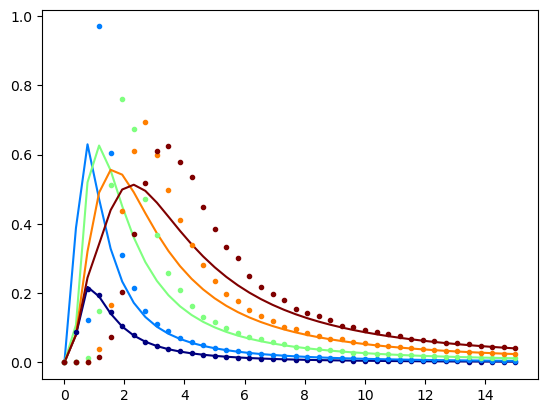

In [76]:
figure()
#ℙfunMF = (T, h) -> (1 .- Mfun0(T, h) .^2) ./ 3
ℙfunLim = (T, h) -> (1 .- Mfun0(T, h) .^2) ./ 4

for n in eachindex(𝒽)
    #plot(T, ℙfunMF(T, 𝒽[n]), color=colors[n], "--")
    #plot(T, ℙfunLim(T, 𝒽[n]), color=colors[n])
    scatter(T, ℙ[:,n], color=colors[n])
end
savefig("figs/Micro_Kubo_Percolation.png")

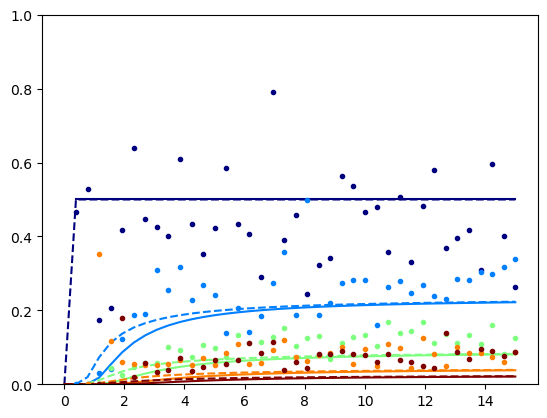

(0.0, 1.0)

In [83]:
figure()
nfun0 = (T) -> 0.5 .* (1 .- tanh.(λ ./ T))
nfun = (T, h) -> 1 ./ (1 .+ exp.(2 .* λ ./ T) .* exp.(h ./ T ./ sqrt.(nfun0(T))))
Kfun = (T, h) -> (2 .* nfun(T, h) ./ T.^2) .* (1 .- nfun(T, h)) .* (1 .- Mfun(T, h)) ./ 2 # additional magnetisation factor for +-+- bond percolation
Kfun0 = (T, h) -> (2 .* nfun0(T) ./ T.^2) .* (1 .- nfun0(T)) .* (1 .- Mfun(T, h)) ./ 2

dim = allComponents ? length(L) : 1

for n in eachindex(𝒽)
    #plot(T, Kfun(T, 𝒽[n]), color=colors[n], "--")
    #plot(T, Kfun0(T, 𝒽[n]), color=colors[n])

    for i in 1:dim
        for j in 1:dim
            plot(T, κ[i, j, :, n], color=colors[n])
            #plotWithError(κ[dim1,dim2,:,n], T, colors[n], κStd[dim1,dim2,:,n])
        end
    end
end
ylim([0, 0.3])
savefig("figs/Micro_Kubo_Conductivity.png")

In [ ]:
figure()
Cfun = (T, h) -> (sech.(1 ./T).^2 + 2 * h^2 .* sech.(h ./T).^2) ./ 2 .* λ ./ T.^2
for n in eachindex(𝒽)
    #plot(T, Cfun(T, 𝒽[n]), color=colors[n])
    plotWithError(C[:,n], T, colors[n], CStd[:,n])
end
ylim([0, 0.3])
savefig("figs/Micro_Kubo_Capacity.png")

In [ ]:
figure()
Dfun = (T, h) -> Kfun(T, h) ./ Cfun(T, h)
Dfun0  = (T, h) -> Kfun0(T, h) ./ Cfun(T, h)
for n in eachindex(𝒽)
    #plot(T, Dfun(T, 𝒽[n]), color=colors[n], "--")
    #plot(T, Dfun0(T, 𝒽[n]), color=colors[n])
    
    for i in 1:dim
        for j in 1:dim
            plot(T, Diff[i, j, :, n], color=colors[n])
            #plotWithError(Diff[dim1,dim2,:,n], T, colors[n], DiffStd[dim1,dim2,:,n])
        end
    end
end
savefig("figs/Micro_Kubo_Diff.png")
ylim([0, 2.0])

In [ ]:
κ = Nothing
C_σ = Nothing
κStd = Nothing 
C_σStd = Nothing

### Diffusive Motion

In [77]:
@everywhere include(dir * "/functions/simulationFunctions/MicroDiffusion.jl")

In [117]:
L = [5, 5, 5]
PBC = [true, true, true]
Basis = DiamondBasis()

therm_runtime = 1000
runtime = 1000
tau = 2:floor(Int64, 0.75*runtime)
num_histories = 50
𝒽 = [0.0] #range(0.0, 2.0, length=7)

T = []; range(0.01, 10.0, length=20);
ℓ = [1, 1]; # floor.(Int64, range(1, prod(L)/4, length=20));


x, δ, Mag, Perc, p, Nv = DiffSim(L, PBC, Basis, therm_runtime, runtime, ℓ, T, 𝒽)
D, α, C, γ, MSD, StepCorr = DiffAnalysis(x, δ, p, runtime, ℓ, T, 𝒽)

In [ ]:
colors = jetmap(length(𝒽))

In [ ]:
Mag = mean(Mag, dims=3)

figure()
for i in eachindex(𝒽)
    if length(T) > 0
        scatter(T, Mag[:,i], color=colors[i])
        #plot(T, Mfun(T, 𝒽[i]), color=colors[i])
    elseif length(ℓ) > 0
        scatter(ℓ, Mag[:,i], color=colors[i])
    end
end
savefig("figs/Magnetisation.png")

In [ ]:
Perc = mean(Perc, dims=3)

figure()
for i in eachindex(𝒽)
    if length(T) > 0
        scatter(T, Perc[:,i], color=colors[i])
    elseif length(ℓ) > 0
        scatter(ℓ, Perc[:,i], color=colors[i])
    end
end

savefig("figs/Percolation.png")

In [85]:
figure()
for t in size(MSD, 2)
    for i in size(MSD, 3)
        if MSD[:,t,i] != [NaN for _ in 1:size(MSD, 1)]
            loglog(MSD[:,t,i], color=colors[i])
            plot(MSD[:,t,i], color=colors[i])
        end
    end
end
#legend(loc = "upper right", bbox_to_anchor = (1.25, 1.0))
savefig("figs/MSD.png")

LoadError: UndefVarError: tmp1 not defined

In [86]:
# step direction autocorrelation
figure()
for t in size(StepCorr, 2)
    for i in size(StepCorr, 3)
        if StepCorr[:,t,i] != [NaN for _ in 1:size(StepCorr, 1)]
            #loglog(abs.(StepCorr[:,t,i]), color=colors[i])
            plot(StepCorr[:,t,i], color=colors[i])
        end
    end
end
savefig("figs/StepCorr.png")

LoadError: UndefVarError: tmp1 not defined

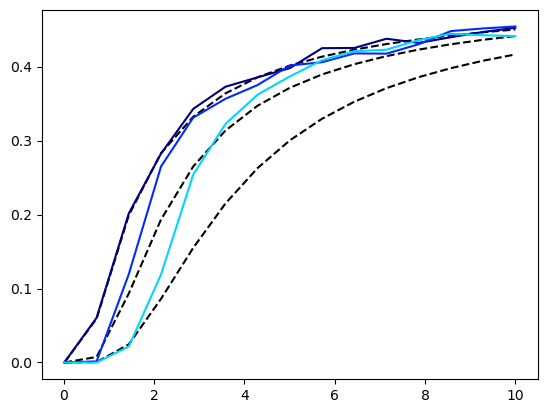

In [127]:
# estimate based on assuming the number of particles is <ϵ_i>/2λ/2 in single vertex approxn

figure() # density of quasiparticles
p = mean(p, dims=3) ./ Nv

if length(T) > 0
    nfun0 = (T) -> (1 .- tanh.(λ ./ T)) ./ 2
    Mfun0 = (T, h) -> tanh.(h ./ T)
    nfun = (T, h) -> nfun0(T .* (1 .- h .* Mfun0(T, h) ./ 2)) # 
    nfun2 = (T, h) -> nfun0(T ./ (1 .+ h .* Mfun0(T, h) ./ 2))
    
    for i in eachindex(𝒽)
        plot(T, p[:,i], color=colors[i])
        #plot(T, nfun(T, 𝒽[i]), color=colors[i], "--")
        #plot(T, nfun2(T, 𝒽[i]), color=colors[i], "--")
    end
elseif length(ℓ) > 0
    pExp = 2 .* ℓ ./ Nv
    
    for i in eachindex(𝒽)
        scatter(ℓ, p[:,i], color=colors[i])
    end
    plot(ℓ, pExp, color=:black, "--")
end
savefig("figs/Quasiparticle Number.png")

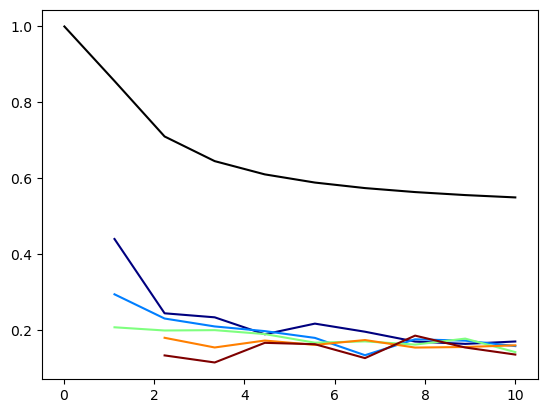

In [256]:
figure() # diffusion coefficient
nfun0 = (T) -> (1 .- tanh.(λ ./ T)) ./ 2
#nfun  = (T, h) -> 1 ./ (1 .+ exp.(2 .* λ ./ T) .* exp.(h ./ T ./ sqrt.(nfun0(T))))
#Dfun  = (T, h) -> (1 .- nfun(T, h)) .* (1 .- Mfun(T, h)) ./ 2
DfunPlus = (T, h) -> (1 .- nfun0(T)) .* (1 .+ Mfun(T, h)) ./ 2
DfunMinus = (T, h) -> (1 .- nfun0(T)) .* (1 .- Mfun(T, h)) ./ 2

#nfun = (T) -> λ == 0 ? 4 .* (exp.(-4 ./ T) .+ exp.(-16 ./ T)) ./ (3 .+ 4 .* exp.(-4 ./ T) .+ exp.(-16 ./ T)) : 0.5 .* (1 .- tanh.(λ ./ T))
#Dfun = (n) -> λ == 0 ? 7/12 .* (1 .- n) : 1 .* (1 .- n)

if length(T) > 0
    for i in eachindex(𝒽)
        plotWithError(D[1,:,i], T, colors[i], D[2,:,i])
        #plot(T, DfunPlus(T, 𝒽[i]), color=colors[i])
        #plot(T, DfunMinus(T, 𝒽[i]), color=colors[i], "--")
    end
elseif length(ℓ) > 0
    #plot(ℓ, Dfun(2 .* ℓ ./ Nv), color=:black)
    for i in eachindex(𝒽)
        plotWithError(D[1,:,i], ℓ, colors[i], D[2,:,i])
    end
end
savefig("figs/Diffusion Coefficient.png")

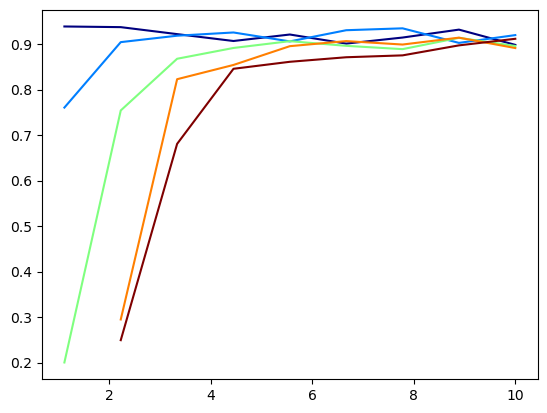

In [257]:
figure() # diffusion exponent
if length(T) > 1
    for i in eachindex(𝒽)
        plotWithError(α[1,:,i], T, colors[i], α[2,:,i])
    end
elseif length(ℓ) > 0
    for i in eachindex(𝒽)
        plotWithError(α[1,:,i], ℓ, colors[i], α[2,:,i])
    end
end
savefig("figs/Diffusion Exponent.png")

In [ ]:
t4 = now()
print("\nTOTAL RUNTIME = ", canonicalize(t4 - t0))